<a href="https://colab.research.google.com/github/nahimaort/Traffic-Signs-Recognition/blob/main/TrafficSigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de señales de tráfico

Vamos a desarrollar una red que reconozca señales de tráfico de tipo precaución. Para ello, vamos a utilizar un dataset hemos extraído de Kaggle: el dataset GTSRB.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Vemos una imagen de ejemplo

Traffic-Signs  Traffic-Signs-2	Traffic-Signs-3  Traffic-Signs-4


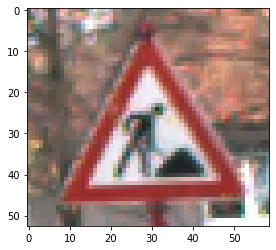

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs/5/00025_00040_00018.png', 'r')
imshow(np.asarray(pil_im))



## Primer modelo

In [ ]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 1840 files belonging to 9 classes.
Using 1472 files for training.
Found 1840 files belonging to 9 classes.
Using 368 files for validation.


In [ ]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
46/46 [==============================] - 319s 6s/step - loss: 2.1783 - accuracy: 0.1977 - val_loss: 1.9917 - val_accuracy: 0.3234
Epoch 2/200
46/46 [==============================] - 6s 113ms/step - loss: 1.4670 - accuracy: 0.5082 - val_loss: 0.9159 - val_accuracy: 0.7418
Epoch 3/200
46/46 [==============================] - 6s 112ms/step - loss: 0.7102 - accuracy: 0.7833 - val_loss: 0.4472 - val_accuracy: 0.9022
Epoch 4/200
46/46 [==============================] - 6s 111ms/step - loss: 0.4390 - accuracy: 0.8655 - val_loss: 0.3541 - val_accuracy: 0.9158
Epoch 5/200
46/46 [==============================] - 6s 111ms/step - loss: 0.3108 - accuracy: 0.8967 - val_loss: 0.2892 - val_accuracy: 0.9103
Epoch 6/200
46/46 [==============================] - 6s 108ms/step - loss: 0.2308 - accuracy: 0.9273 - val_loss: 0.2572 - val_accuracy: 0.9348
Epoch 7/200
46/46 [==============================] - 6s 114ms/step - loss: 0.1960 - accuracy: 0.9307 - val_loss: 0.2374 - val_accuracy: 0.9538


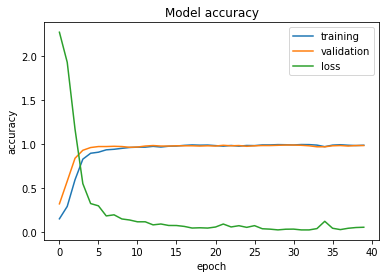

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.9143    1.0000    0.9552        32
           1     0.9773    0.9556    0.9663        45
           2     1.0000    0.9362    0.9670        47
           3     1.0000    0.9796    0.9897        49
           4     0.9697    1.0000    0.9846        32
           5     1.0000    0.9730    0.9863        37
           6     0.9808    0.9808    0.9808        52
           7     0.9444    0.9714    0.9577        35
           8     0.9750    1.0000    0.9873        39

    accuracy                         0.9755       368
   macro avg     0.9735    0.9774    0.9750       368
weighted avg     0.9765    0.9755    0.9756       368



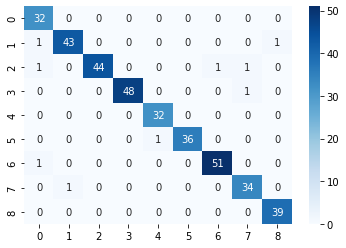

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [ ]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs/2/00021_00006_00000.png', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1


In [ ]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/imagenes/imagen5.png', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

5
